In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from pathlib import Path
from typing import Optional
from itertools import product

from utils import SECTORS, DR_PRICES, NG_PRICES, ERS, SECTOR_NICE_NAMES, DR_PRICE_NICE_NAMES, METHOD_NICE_NAMES, get_datapoint

In [88]:
# User defined variables
AS_PERCENTAGE = True # display heatmaps as percentage of base case
CMAP_OVERRIDE = None # https://matplotlib.org/stable/users/explain/colors/colormaps.html

In [89]:
# Path handling (DO NOT CHANGE)
FIGURES_BASE = Path("..","figures")
FIGURES_METHOD = Path(FIGURES_BASE, "other")

In [90]:
# Formatting (DO NOT CHANGE)
OBJ_COST_SCALER = 1 if AS_PERCENTAGE else 1e9
CMAP = CMAP_OVERRIDE if CMAP_OVERRIDE else "coolwarm" if AS_PERCENTAGE else "crest"
OBJ_COST_LABEL = "Deviation from Base (%)" if AS_PERCENTAGE else "($B)"

SHARE_YLABEL = True if AS_PERCENTAGE else False

In [91]:
def get_template_dataframe(include_base: bool = False) -> pd.DataFrame:
    prices = DR_PRICES.copy()
    if include_base:
        prices.insert(0, "None")
    sectors = SECTORS.copy()
    if include_base:
        sectors.insert(0, "None")
    return pd.DataFrame([],
        index=sectors,
        columns=prices
    )
get_template_dataframe(include_base=False)

,high,mid,low,vlow
e,NaN,NaN,NaN,NaN
t,NaN,NaN,NaN,NaN
et,NaN,NaN,NaN,NaN


In [92]:
def get_heatmap_data(result: str, metric: str, region: str, scenario: str, method: str, as_percentage: bool = False) -> dict[str, pd.DataFrame]:
    assert region in ["caiso", "new_england", "caiso_cc"]
    assert scenario in ["ng", "er"]
    assert method in ["static", "dynamic"]
    data = {}
    scenarios = NG_PRICES if scenario == "ng" else ERS
    for scenario in scenarios:
        include_base = False if as_percentage else True
        hm = get_template_dataframe(include_base=include_base)
        for sector, dr_price in product(SECTORS, DR_PRICES):
            df = get_datapoint(
                region=region,
                scenario=scenario,
                result=result,
                sector=sector,
                dr_price=dr_price,
                method=method
            )
            datapoint = df.at[metric, "value"]
            hm.at[sector, dr_price] = datapoint
        df = get_datapoint(region=region, scenario=scenario, result=result)
        datapoint = df.at[metric, "value"]
        if as_percentage:
            hm = (hm - datapoint).div(datapoint).mul(100).round(2)
        else:
            datapoint = df.at[metric, "value"]
            hm.at["None", "None"] = datapoint
        data[scenario] = hm.astype(float)
    return data

In [93]:
def generate_heatmap_stacked(data: dict[str, pd.DataFrame], scaler: Optional[float] = None, share_ylabel: Optional[bool] = False, **kwargs) -> tuple[plt.figure, plt.axes]:
    
    if not scaler:
        scaler = 1
    
    ncols = 1
    nrows = 2
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))

    col = 0
    
    title = kwargs.get("title", "")
    if title:
        fig.suptitle(title, fontsize=20)
        
    custom_title = kwargs.get("custom_title", "")
    
    ylabel = kwargs.get("ylabel", "")
    
    cmap = kwargs.get("cmap", "viridis")
    
    if share_ylabel:
        all_values = pd.concat(
            [df.T.rename(index=DR_PRICE_NICE_NAMES).rename(columns=SECTOR_NICE_NAMES).div(scaler).stack()
             for df in data.values()]
        )
        vmin, vmax = all_values.min(), all_values.max()

        # force range to be symmetric around 0 so center always stays at 0
        abs_max = max(abs(vmin), abs(vmax))
        vmin, vmax = -abs_max, abs_max

        norm = TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax)
    else:
        vmin = vmax = None
        norm = None
    
    heatmaps = [] # for shared colorbar
    
    for method, df in data.items():
        
        df = df.T.rename(index=DR_PRICE_NICE_NAMES).rename(columns=SECTOR_NICE_NAMES)
        
        if custom_title:
            title = custom_title
        elif method in METHOD_NICE_NAMES:
            title = METHOD_NICE_NAMES[method]
        else:
            raise ValueError(f"Invalid method: {method}")
        
        df = df.div(scaler).round(2)
            
        hm = sns.heatmap(
            df, 
            annot=True, 
            cmap=cmap,
            cbar=False,  # Always False since we'll create a single shared colorbar
            ax=axs[col], 
            fmt=".1f", 
            yticklabels=True,
            annot_kws={
                "fontsize":"x-large"
            },
            vmin=vmin,
            vmax=vmax,
            norm=norm
        )
        heatmaps.append(hm)
        
        axs[col].set_title(title, fontsize=18, pad=20)
        
        axs[col].tick_params(axis="y", labelrotation=0, labelsize=14)
        axs[col].tick_params(axis="x", labelrotation=45, labelsize=14)
        
        col += 1
        
    # fig.supxlabel("Demand Response Sector", fontsize =18)
    fig.supylabel("Demand Response Cost", fontsize =18)
        
    fig.tight_layout(rect=[0.02, 0, 0.80, 1])
        
    if share_ylabel:
        # Create a single colorbar that spans both heatmaps
        cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        cbar = fig.colorbar(
            heatmaps[0].collections[0],
            cax=cbar_ax,
            orientation="vertical",
            norm=norm
        )
        cbar.ax.tick_params(labelsize=14)
        if ylabel:
            cbar.ax.set_ylabel(ylabel, rotation=90, labelpad=10, y=0.5, fontsize=16)
        
    return fig, axs

In [94]:
def generate_heatmap_3col(data: dict[str, pd.DataFrame], scaler: Optional[float] = None, share_ylabel: Optional[bool] = False, **kwargs) -> tuple[plt.figure, plt.axes]:
    
    if not scaler:
        scaler = 1
    
    ncols = 3
    nrows = 1
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows))

    col = 0
    
    title = kwargs.get("title", "")
    if title:
        fig.suptitle(title, fontsize=20)
        
    custom_title = kwargs.get("custom_title", "")
    
    ylabel = kwargs.get("ylabel", "")
    
    cmap = kwargs.get("cmap", "viridis")
    
    data = {x: y.fillna(0) for x, y in data.items()}
    
    if share_ylabel:
        all_values = pd.concat(
            [df.T.rename(index=DR_PRICE_NICE_NAMES).rename(columns=SECTOR_NICE_NAMES).div(scaler).stack()
             for df in data.values()]
        )
        vmin, vmax = all_values.min(), all_values.max()

        # force range to be symmetric around 0 so center always stays at 0
        abs_max = max(abs(vmin), abs(vmax))
        vmin, vmax = -abs_max, abs_max
        
        if vmin == vmax:
            vmin -= 1
            vmax += 1
            
        norm = TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax)
    else:
        vmin = vmax = None
        norm = None
    
    heatmaps = [] # for shared colorbar
    
    for region, df in data.items():
        
        df = df.T.rename(index=DR_PRICE_NICE_NAMES).rename(columns=SECTOR_NICE_NAMES)
        
        if custom_title:
            title = custom_title
        elif region == "caiso":
            title = "CAISO"
        elif region == "caiso_cc":
            title = "CAISO Capacity Constrained"
        elif region == "new_england":
            title = "New England"
        else:
            raise ValueError(f"Invalid region: {region}")
        
        df = df.div(scaler).round(2)
        
        if col == 0:
            yticklabels = True
        else:
            yticklabels = False
            
        hm = sns.heatmap(
            df, 
            annot=True, 
            cmap=cmap,
            cbar=False if share_ylabel else True,
            ax=axs[col], 
            fmt=".1f", 
            yticklabels=yticklabels,
            annot_kws={
                "fontsize":"x-large"
            },
            vmin=vmin,
            vmax=vmax,
            norm=norm
        )
        heatmaps.append(hm)

        if not share_ylabel:
            colorbar = hm.collections[0].colorbar
            colorbar.ax.tick_params(labelsize=14)
            if ylabel:
                colorbar.ax.set_ylabel(ylabel, rotation=90, labelpad=10, y=0.5, fontsize=16)
        
        axs[col].set_title(title, fontsize=18, pad=20)
        
        axs[col].tick_params(axis="y", labelrotation=0, labelsize=14)
        axs[col].tick_params(axis="x", labelrotation=45, labelsize=14)
        
        col += 1
        
    # fig.supxlabel("Demand Response Sector", fontsize =18)
    fig.supylabel("Demand Response Cost", fontsize =18)
        
    fig.tight_layout(rect=[0.02, 0, 0.80, 1])
        
    if share_ylabel:
        cbar = fig.colorbar(
            heatmaps[0].collections[0],
            ax=axs,
            orientation="vertical",
            fraction=0.02,
            pad=0.02,
            norm=norm
        )
        cbar.ax.tick_params(labelsize=14)
        if ylabel:
            cbar.ax.set_ylabel(ylabel, rotation=90, labelpad=10, y=0.5, fontsize=16)
            
        
        
    return fig, axs

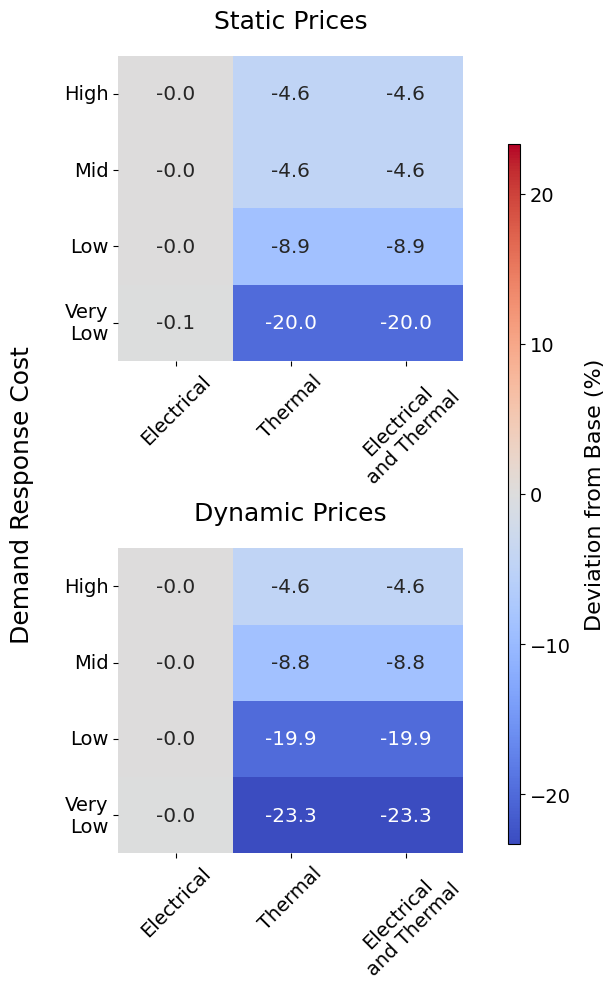

In [95]:
data_static = get_heatmap_data("cost", "objective_adj", "caiso", "ng", "static", as_percentage=AS_PERCENTAGE)
data_dynamic = get_heatmap_data("cost", "objective_adj", "caiso", "ng", "dynamic", as_percentage=AS_PERCENTAGE)

data = {}
data["static"] = data_static["mgas"]
data["dynamic"] = data_dynamic["mgas"]

fig, _ = generate_heatmap_stacked(data, scenario="mgas", scaler=OBJ_COST_SCALER, title="", ylabel=OBJ_COST_LABEL, share_ylabel=True, cmap=CMAP)

save_f = Path(FIGURES_METHOD, "static_vs_dynamic_caiso.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

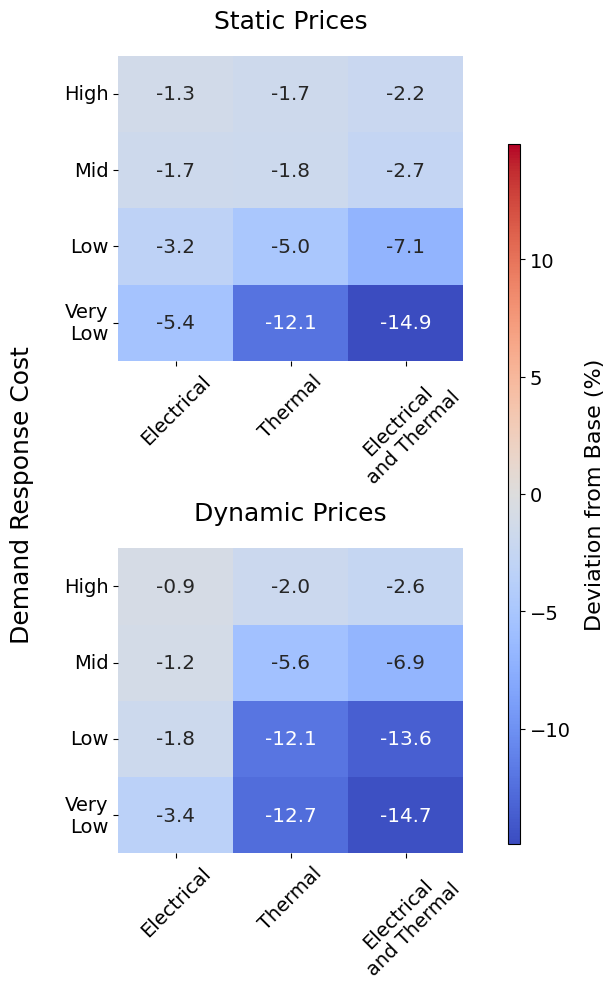

In [96]:
data_static = get_heatmap_data("cost", "objective_adj", "caiso_cc", "ng", "static", as_percentage=AS_PERCENTAGE)
data_dynamic = get_heatmap_data("cost", "objective_adj", "caiso_cc", "ng", "dynamic", as_percentage=AS_PERCENTAGE)

data = {}
data["static"] = data_static["mgas"]
data["dynamic"] = data_dynamic["mgas"]

fig, _ = generate_heatmap_stacked(data, scenario="mgas", scaler=OBJ_COST_SCALER, title="", ylabel=OBJ_COST_LABEL, share_ylabel=True, cmap=CMAP)

save_f = Path(FIGURES_METHOD, "static_vs_dynamic_caiso_cc.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

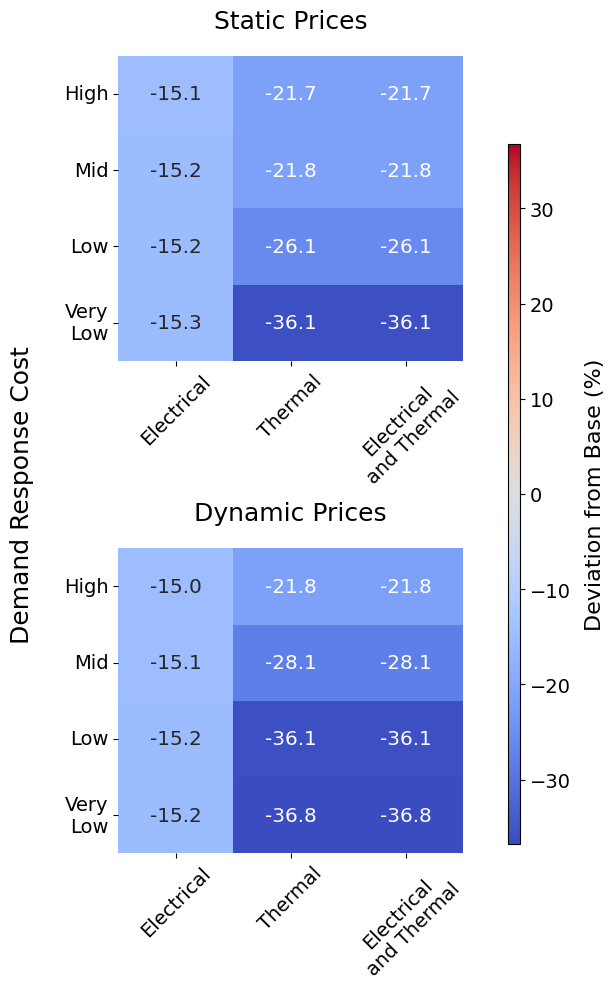

In [97]:
data_static = get_heatmap_data("cost", "objective_adj", "new_england", "ng", "static", as_percentage=AS_PERCENTAGE)
data_dynamic = get_heatmap_data("cost", "objective_adj", "new_england", "ng", "dynamic", as_percentage=AS_PERCENTAGE)

data = {}
data["static"] = data_static["mgas"]
data["dynamic"] = data_dynamic["mgas"]

fig, _ = generate_heatmap_stacked(data, scenario="mgas", scaler=OBJ_COST_SCALER, title="", ylabel=OBJ_COST_LABEL, share_ylabel=True, cmap=CMAP)

save_f = Path(FIGURES_METHOD, "static_vs_dynamic_new_england.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

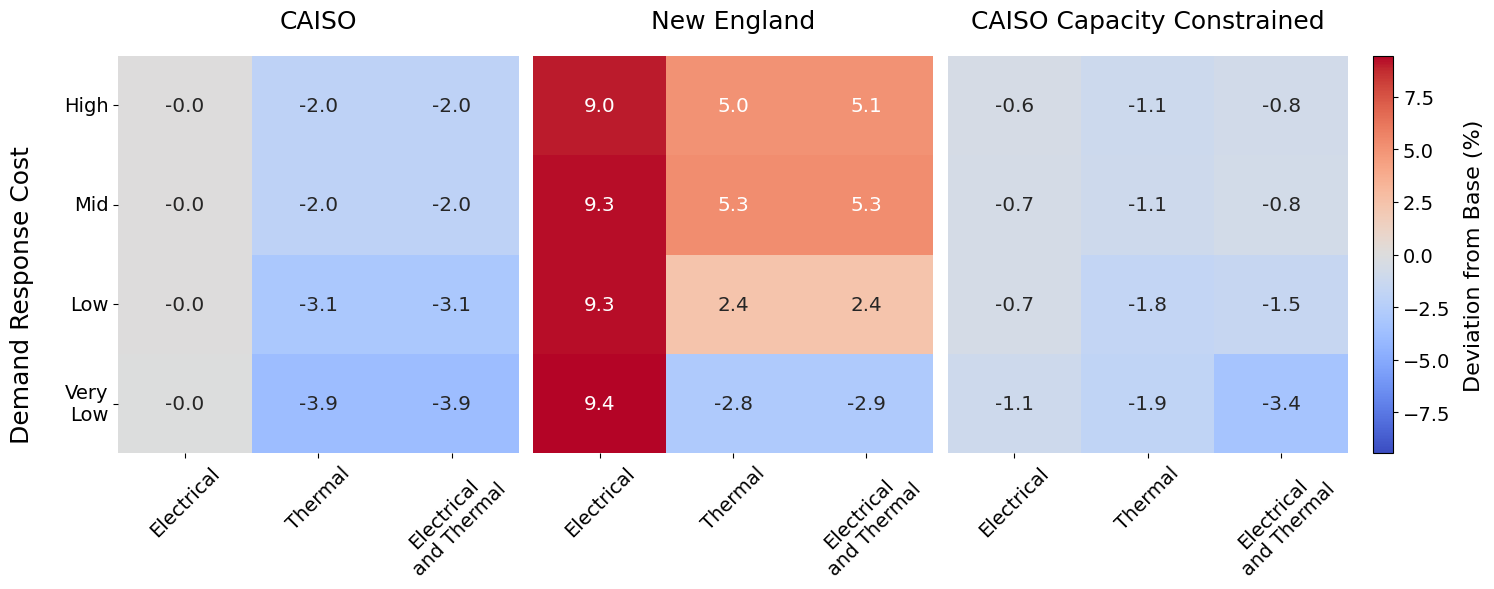

In [98]:
data_caiso = get_heatmap_data("emissions", "Emissions CO2 T", "caiso", "ng", "static", as_percentage=AS_PERCENTAGE)
data_new_england = get_heatmap_data("emissions", "Emissions CO2 T", "new_england", "ng", "static", as_percentage=AS_PERCENTAGE)
data_caiso_cc = get_heatmap_data("emissions", "Emissions CO2 T", "caiso_cc", "ng", "static", as_percentage=AS_PERCENTAGE)

data = {}
data["caiso"] = data_caiso["mgas"]
data["new_england"] = data_new_england["mgas"]
data["caiso_cc"] = data_caiso_cc["mgas"]

fig, _ = generate_heatmap_3col(data, scenario="mgas", scaler=OBJ_COST_SCALER, title="", ylabel=OBJ_COST_LABEL, share_ylabel=True, cmap=CMAP)

save_f = Path(FIGURES_METHOD, "emissions_comparison.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")